## Import Libraries

In [1]:
!pip install tensorflow==2.15.0

In [2]:
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

2024-06-14 09:05:03.118295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 09:05:03.118409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 09:05:03.224818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data 

In [3]:
# Generate data paths with labels
data_dir = '/kaggle/input/capstone-dataset-children-autism/Autistic Children Emotion Merge'
filepaths = []
labels = []

# Path to folders
folds = os.listdir(data_dir)

# join path to folder and then path to each file, fyuhh
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

df0 = pd.concat([Fseries, Lseries], axis= 1)
df0

,filepaths,labels
0,/kaggle/input/capstone-dataset-children-autism...,joy
1,/kaggle/input/capstone-dataset-children-autism...,joy
2,/kaggle/input/capstone-dataset-children-autism...,joy
3,/kaggle/input/capstone-dataset-children-autism...,joy
4,/kaggle/input/capstone-dataset-children-autism...,joy
...,...,...
826,/kaggle/input/capstone-dataset-children-autism...,anger
827,/kaggle/input/capstone-dataset-children-autism...,anger
828,/kaggle/input/capstone-dataset-children-autism...,anger
829,/kaggle/input/capstone-dataset-children-autism...,anger


In [4]:
df_counts = df0['labels'].value_counts().sort_index()
df_counts

labels
Natural      55
anger        69
fear         33
joy         392
sadness     214
surprise     68
Name: count, dtype: int64

## Data Augmented

In [5]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
from PIL import Image
import Augmentor

label = df_counts.index

for i in label:
    input_dir = f"/kaggle/input/capstone-dataset-children-autism/Autistic Children Emotion Merge/{i}"
    output_dir = f"/kaggle/working/final_dataset/{i}"
    
    p = Augmentor.Pipeline(source_directory=input_dir, output_directory=output_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
#     p.flip_top_bottom(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
#     p.crop_random(probability=0.5, percentage_area=0.3)
    p.resize(probability=1.0, width=224, height=224)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
    
#     n = 500 - df_counts[i]
    n = 500
    
    try:
        p.sample(n)
    except Exception as e:
        print(f"Error processing {i}: {str(e)}")

Initialised with 55 image(s) found.
Output directory set to /kaggle/working/final_dataset/Natural.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B786F7D3310>: 100%|██████████| 500/500 [00:04<00:00, 117.09 Samples/s]


Initialised with 69 image(s) found.
Output directory set to /kaggle/working/final_dataset/anger.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B78FC249AE0>: 100%|██████████| 500/500 [00:04<00:00, 102.40 Samples/s]


Initialised with 33 image(s) found.
Output directory set to /kaggle/working/final_dataset/fear.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B786EDB3460>: 100%|██████████| 500/500 [00:04<00:00, 106.75 Samples/s]


Initialised with 392 image(s) found.
Output directory set to /kaggle/working/final_dataset/joy.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B786EE3F2E0>: 100%|██████████| 500/500 [00:05<00:00, 90.74 Samples/s] 


Initialised with 214 image(s) found.
Output directory set to /kaggle/working/final_dataset/sadness.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B786EE32A10>: 100%|██████████| 500/500 [00:05<00:00, 97.40 Samples/s]


Initialised with 68 image(s) found.
Output directory set to /kaggle/working/final_dataset/surprise.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B786EDB3D30>: 100%|██████████| 500/500 [00:03<00:00, 125.19 Samples/s]


In [7]:
# Generate data paths with labels
aug_data_dir = '/kaggle/working/final_dataset'
labels = []

# Path to folders
folds = os.listdir(aug_data_dir)

# join path to folder and then path to each file, fyuhh
for fold in folds:
    foldpath = os.path.join(aug_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

df1 = pd.concat([Fseries, Lseries], axis= 1)
df1.dropna(inplace = True)
df1

,filepaths,labels
0,/kaggle/input/capstone-dataset-children-autism...,joy
1,/kaggle/input/capstone-dataset-children-autism...,joy
2,/kaggle/input/capstone-dataset-children-autism...,joy
3,/kaggle/input/capstone-dataset-children-autism...,joy
4,/kaggle/input/capstone-dataset-children-autism...,joy
...,...,...
2995,/kaggle/working/final_dataset/fear/fear_origin...,anger
2996,/kaggle/working/final_dataset/fear/fear_origin...,anger
2997,/kaggle/working/final_dataset/fear/fear_origin...,anger
2998,/kaggle/working/final_dataset/fear/fear_origin...,anger


In [8]:
# df2 = pd.concat([df0, df1], ignore_index=True, axis = 0)
# df2

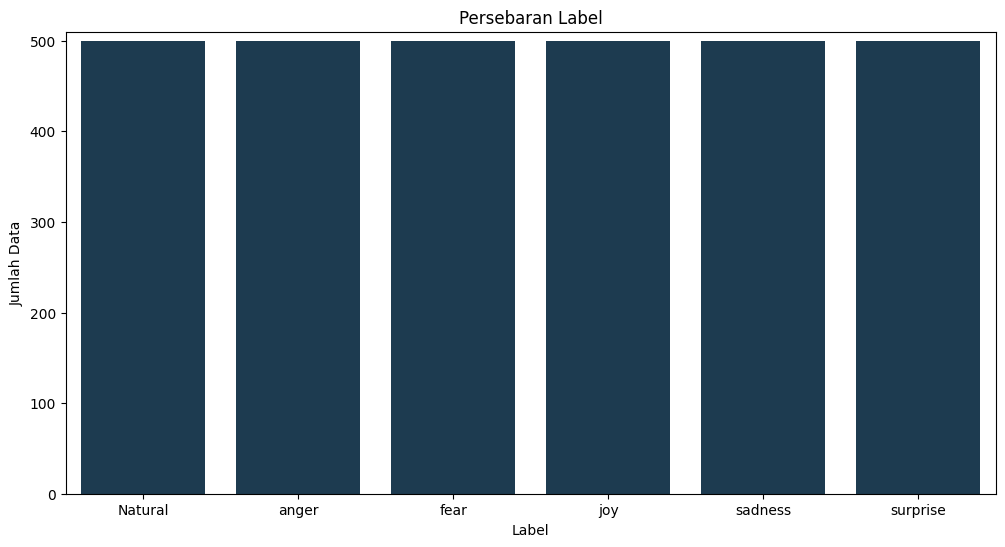

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot1(df, label_column='labels'):
    """
    Membuat barplot untuk memperlihatkan distribusi label pada satu DataFrame.

    Args:
    df (pd.DataFrame): DataFrame yang berisi data dengan kolom label.
    label_column (str): Nama kolom yang berisi label.
    """
    # Menghitung jumlah data per label
    label_counts = df[label_column].value_counts().sort_index()

    # Membuat DataFrame untuk plot
    counts_df = pd.DataFrame({'Label': label_counts.index, 'Jumlah Data': label_counts.values})
    counts_df['Label'] = counts_df['Label'].replace('dermatofibroma', 'dermato-\nfibroma')

    # Membuat barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Label', y='Jumlah Data', data=counts_df, palette=['#143d59'])

    # Menambahkan judul dan label sumbu
    plt.title('Persebaran Label')
    plt.xlabel('Label')
    plt.ylabel('Jumlah Data')

    # Mengatur batas sumbu y
    plt.ylim(0, counts_df['Jumlah Data'].max() + 10)

    # Menampilkan label dalam dua baris jika panjang
    labels = counts_df['Label'].unique()
    plt.xticks(range(len(labels)), [label.replace(" ", "\n") for label in labels])

    # Menampilkan plot
    plt.show()

plot1(df1)

## Splitting Data

In [10]:
# import os
# import pandas as pd
# from sklearn.model_selection import train_test_split
# import shutil

# # Membuat direktori untuk train dan test
# base_dir = '/kaggle/working/'
# train_dir = os.path.join(base_dir, 'train')
# test_dir = os.path.join(base_dir, 'test')

# # Fungsi untuk membuat direktori jika belum ada
# def create_dir(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# create_dir(base_dir)
# create_dir(train_dir)
# create_dir(test_dir)

# # Splitting the data
# train_list = []
# test_list = []

# for label in df2['labels'].unique():
#     label_df = df2[df2['labels'] == label]
#     train_data, test_data = train_test_split(label_df, test_size=0.05, random_state=42)
    
#     train_list.append(train_data)
#     test_list.append(test_data)
    
#     # Membuat direktori untuk masing-masing label dalam train dan test
#     label_train_dir = os.path.join(train_dir, label)
#     label_test_dir = os.path.join(test_dir, label)
    
#     create_dir(label_train_dir)
#     create_dir(label_test_dir)
    
#     # Menyalin file ke direktori train
#     for filepath in train_data['filepaths']:
#         shutil.copy(filepath, label_train_dir)
    
#     # Menyalin file ke direktori test
#     for filepath in test_data['filepaths']:
#         shutil.copy(filepath, label_test_dir)

# # Menggabungkan kembali hasil split menjadi satu DataFrame (opsional)
# train_df = pd.concat(train_list)
# test_df = pd.concat(test_list)

# print("Training data:")
# print(train_df['labels'].value_counts())
# print("\nTesting data:")
# print(test_df['labels'].value_counts())

> ### Train

In [11]:
# # Generate data paths with labels
# train_data_dir = '/kaggle/working/train'
# filepaths = []
# labels = []

# # Path to folders
# folds = os.listdir(train_data_dir)

# # join path to folder and then path to each file, fyuhh
# for fold in folds:
#     foldpath = os.path.join(train_data_dir, fold)
#     filelist = os.listdir(foldpath)
#     for file in filelist:
#         fpath = os.path.join(foldpath, file)
        
#         filepaths.append(fpath)
#         labels.append(fold)

# # Concatenate data paths with labels into one dataframe
# Fseries = pd.Series(filepaths, name= 'filepaths')
# Lseries = pd.Series(labels, name='labels')

# train_df = pd.concat([Fseries, Lseries], axis= 1)

In [12]:
# train_df.labels.value_counts()
# train_df

> ### Test

In [13]:
# # like train process 
# test_data_dir = '/kaggle/working/test'
# filepaths = []
# labels = []

# folds = os.listdir(test_data_dir)
# for fold in folds:
#     foldpath = os.path.join(test_data_dir, fold)
#     filelist = os.listdir(foldpath)
#     for file in filelist:
#         fpath = os.path.join(foldpath, file)
        
#         filepaths.append(fpath)
#         labels.append(fold)

# # Concatenate data paths with labels into one dataframe
# Fseries = pd.Series(filepaths, name= 'filepaths')
# Lseries = pd.Series(labels, name='labels')
# test_df = pd.concat([Fseries, Lseries], axis= 1)

In [14]:
# test_df

In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Menghitung jumlah data per label untuk train dan test
# train_counts = train_df['labels'].value_counts().sort_index()
# test_counts = test_df['labels'].value_counts().sort_index()

# # Menggabungkan data train dan test untuk membuat barplot
# counts_df = pd.DataFrame({'Label': train_counts.index, 'Train': train_counts.values, 'Validasi': test_counts.values})
# # counts_df['Label'] = counts_df['Label'].replace('dermatofibroma', 'dermato-\nfibroma')

# # Mengubah data menjadi format long
# counts_df = counts_df.melt(id_vars='Label', var_name='Dataset', value_name='Jumlah Data')

# # Membuat barplot
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Label', y='Jumlah Data', hue='Dataset', data=counts_df, palette=['#143d59', '#f4b41a'])

# # Menambahkan judul dan label sumbu
# plt.title('Persebaran Label')
# plt.xlabel('Label')
# plt.ylabel('Jumlah Data')

# # Mengatur batas sumbu y
# plt.ylim(0, 500)

# # Menampilkan label dalam dua baris jika panjang
# labels = counts_df['Label'].unique()
# plt.xticks(range(len(labels)), [label.replace(" ", "\n") for label in labels])

# # Menghapus judul dari legend
# plt.legend(loc='upper right')

# # Menampilkan plot
# plt.show()

> ## Processing

In [16]:
# # resize image
# batch_size = 50
# img_size = (224, 224)
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)

# train_gen = ImageDataGenerator(
#                         rotation_range=40,
# #                         width_shift_range=0.2,
# #                         height_shift_range=0.2,
#                         rescale=1./255,
#                         shear_range=0.2,
#                         zoom_range=0.2,
#                         horizontal_flip=True,
#                         fill_mode='nearest')

# test_gen = ImageDataGenerator(rescale=1.0/255.)

# # train_gen = train_gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
# #                                     color_mode= 'rgb', shuffle = True, batch_size = batch_size)

# # test_gen = test_gen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
# #                                     color_mode= 'rgb', shuffle = False, batch_size = batch_size)

# train_gen = train_gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle = True, batch_size = batch_size)

# test_gen = test_gen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle = False, batch_size = batch_size)

In [17]:
import pathlib

training_main = pathlib.Path('/kaggle/working/final_dataset')
image_count_train = len(list(training_main.glob('*/*.jpg')))
print(image_count_train)

2976


In [18]:
batch_size = 50
img_size = (224, 224)

train_gen = tf.keras.preprocessing.image_dataset_from_directory(
  training_main,
  shuffle = True,
  seed = 123,
  validation_split = 0.1,
  subset = 'training',
  image_size = img_size,
  batch_size = batch_size)

test_gen = tf.keras.preprocessing.image_dataset_from_directory(
  training_main,
  shuffle = False,
  seed = 123,
  validation_split = 0.1,
  subset = 'validation',
  image_size = img_size,
  batch_size = batch_size)

Found 3000 files belonging to 6 classes.
Using 2700 files for training.
Found 3000 files belonging to 6 classes.
Using 300 files for validation.


> ## Samples Of The Data


In [19]:
# g_dict = train_gen.class_indices     
# classes = list(g_dict.keys())       

# # Dictionary to store one image per class
# class_images = {class_name: None for class_name in classes}
# class_labels = {class_name: None for class_name in classes}

# # Fetch batches until we have one image per class
# while any(img is None for img in class_images.values()):
#     images, labels = next(train_gen)
#     for i in range(len(images)):
#         index = np.argmax(labels[i])
#         class_name = classes[index]
#         if class_images[class_name] is None:
#             class_images[class_name] = images[i]
#             class_labels[class_name] = labels[i]
#         # Break if we have found images for all classes
#         if not any(img is None for img in class_images.values()):
#             break

# # Plot the images
# plt.figure(figsize=(8, 4))

# for i, class_name in enumerate(classes):
#      plt.subplot(2, 4, i + 1)
#      image = class_images[class_name]        
#      plt.imshow(image)
#      plt.title(class_name, color='blue', fontsize=12)
#      plt.axis('off')

# plt.tight_layout()
# plt.show()


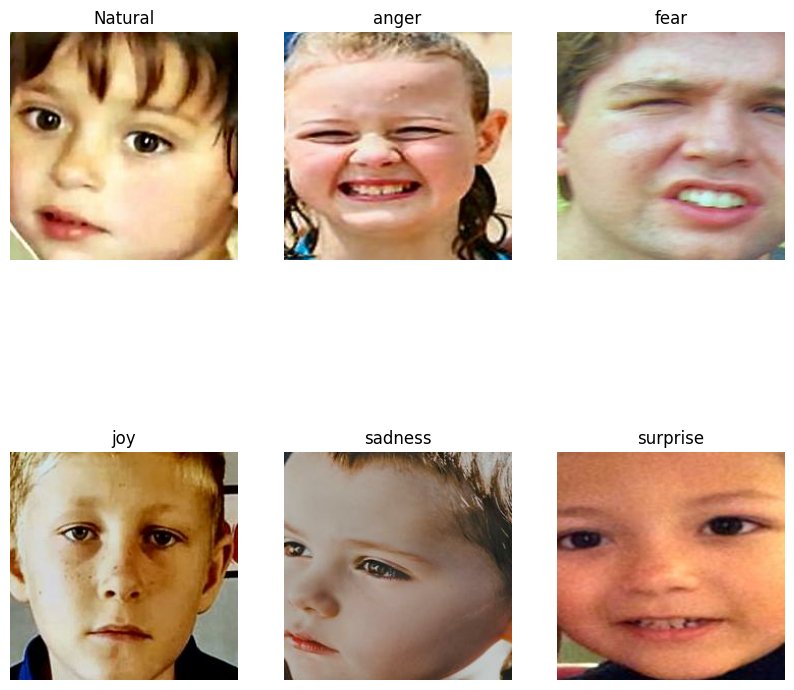

In [20]:
plt.figure(figsize=(10, 10))
for image, label in train_gen.take(1):
    for i in range (6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(df_counts.index[i])
        plt.axis("off")
     

# Modelling

# 1. CNN (Baseline)


In [21]:
from tensorflow.keras.layers import MaxPooling2D
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# class_count = len(list(train_gen.class_indices.keys()))

model1 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
  
    Flatten(),
    
    Dense(512,activation = "relu"),
    Dropout(0.3),
#     Dense(128,activation = "relu"),
    Dense(6, activation = "softmax")
])

model1.compile(Adam(learning_rate= 0.001), loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy')>0.90) and (logs.get('val_accuracy')>0.90)):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [23]:
epochs = 5

steps_per_epoch = 2700 // batch_size
validation_steps = 300 // batch_size

callback = myCallback()

history1 = model1.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
                    validation_data = test_gen, validation_steps =  validation_steps, shuffle = False, callbacks = callback)

Epoch 1/5


I0000 00:00:1718355984.330575     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 [==============================] - 30s 266ms/step - loss: 110.3882 - accuracy: 0.1641 - val_loss: 1.7864 - val_accuracy: 0.0233
Epoch 2/5
54/54 [==============================] - 14s 262ms/step - loss: 1.7916 - accuracy: 0.1500 - val_loss: 1.7814 - val_accuracy: 0.1033
Epoch 3/5
54/54 [==============================] - 14s 262ms/step - loss: 1.7906 - accuracy: 0.1622 - val_loss: 1.7655 - val_accuracy: 0.1167
Epoch 4/5
54/54 [==============================] - 14s 262ms/step - loss: 1.7868 - accuracy: 0.1700 - val_loss: 1.6985 - val_accuracy: 0.2300
Epoch 5/5
54/54 [==============================] - 14s 262ms/step - loss: 1.7826 - accuracy: 0.1759 - val_loss: 1.7646 - val_accuracy: 0.0333


In [24]:
# Save the model
# model1.save('Model1.h5')

> # Model Performance

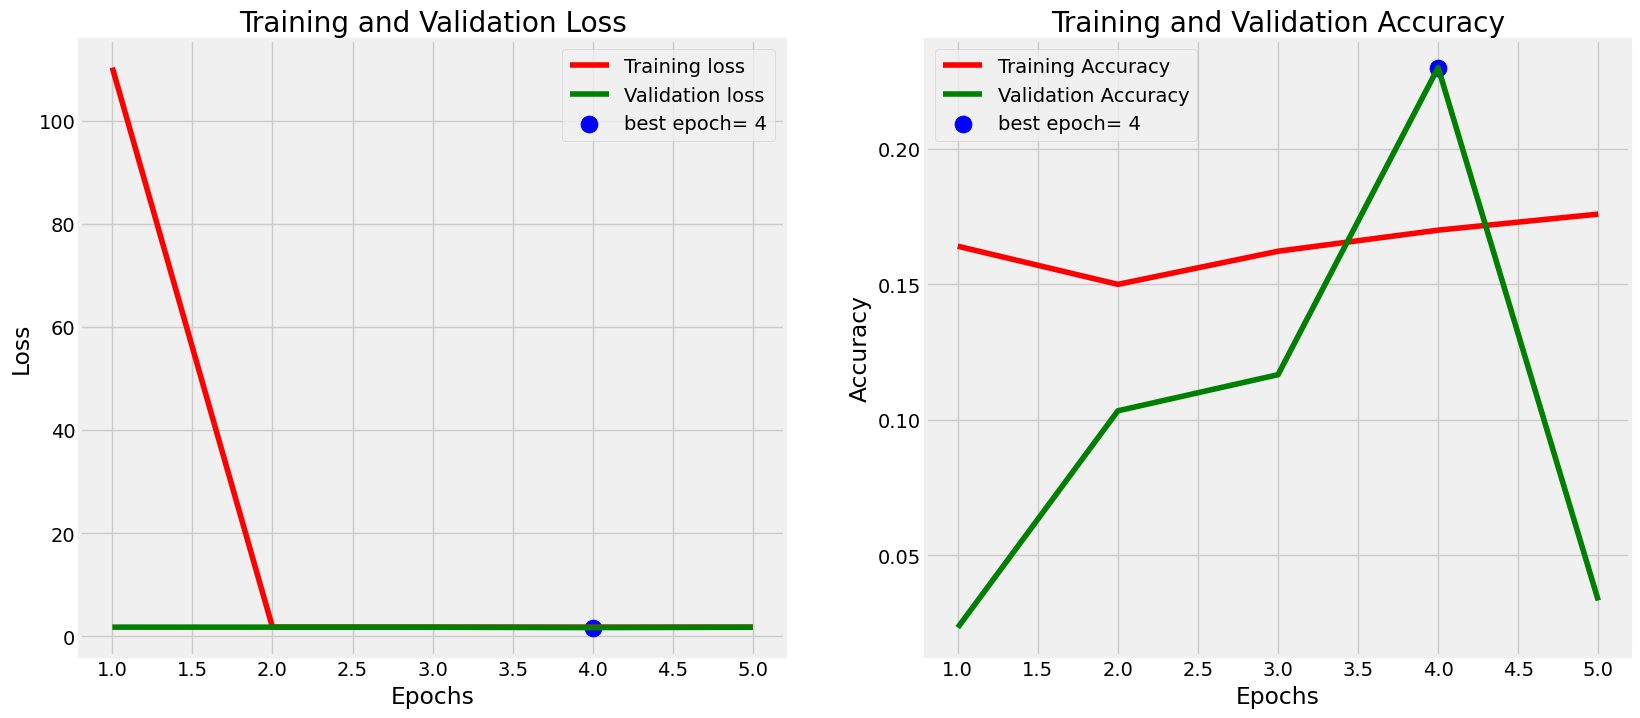

In [25]:
# Define needed variables
def f_history(history = history1):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

f_history(history1)

> ## Classification Report

In [26]:
# g_dict = train_gen.class_indices     
# classes = list(g_dict.keys())       

# preds = model1.predict_generator(test_gen)
# y_pred = np.argmax(preds, axis=1)

# # Classification report
# print(classification_report(test_gen.classes, y_pred, target_names= classes))

> ## Confusion Matrics 

In [27]:
# import itertools
# g_dict = test_gen.class_indices
# classes = list(g_dict.keys())

#     # Confusion matrix
# def f_cm(y_pred = y_pred):
#     cm = confusion_matrix(test_gen.classes, y_pred)

#     plt.figure(figsize= (10, 10))
#     plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.colorbar()

#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation= 45)
#     plt.yticks(tick_marks, classes)


#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

#     plt.tight_layout()
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')

#     plt.show()

# f_cm(y_pred)

## Transfer Learning

In [28]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, DenseNet201, ResNet152V2

### 0. ALL MODEL

In [29]:
# import pandas as pd
# from tensorflow.keras.applications import (
#     MobileNetV2, InceptionV3, VGG16, VGG19, ResNet50, InceptionResNetV2,
#     DenseNet121, DenseNet169, DenseNet201,
#     NASNetLarge, NASNetMobile,
#     EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
#     Xception, MobileNet,
#     ResNet101, ResNet152,
#     ResNet101V2, ResNet152V2,
#     ResNet50V2
# )
# from tensorflow.keras import layers, Model
# from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def create_and_train_model(base_model_class, input_shape, class_count, epochs, train_gen, test_gen, steps_per_epoch, validation_steps):
#     base_model = base_model_class(input_shape = input_shape, include_top = False, weights='imagenet') #
#     base_model.trainable = False

#     last_layer = base_model.layers[-1]
#     last_output = last_layer.output

#     x = layers.Flatten()(last_output)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.Dense(class_count, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=x)
#     model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
#     history = model.fit(
#         x=train_gen,
#         epochs=epochs,
#         steps_per_epoch=steps_per_epoch,
#         validation_data=test_gen,
#         validation_steps=validation_steps,
#         shuffle = False,
#         verbose = 1  # Set to 1 to see the progress
#     )

#     train_accuracy = history.history['accuracy'][-1]
#     val_accuracy = history.history['val_accuracy'][-1]
#     max_train_accuracy = max(history.history['accuracy'])
#     max_val_accuracy = max(history.history['val_accuracy'])

#     return train_accuracy, val_accuracy, max_train_accuracy, max_val_accuracy, history

# def evaluate_models(models, input_shape, class_count, epochs, train_gen, test_gen, steps_per_epoch, validation_steps):
#     results = []

#     for model_name, model_class in models.items():
#         print(f"Evaluating model: {model_name}")
#         train_acc, val_acc, max_train_acc, max_val_acc, history = create_and_train_model(
#             model_class, input_shape, class_count, epochs, train_gen, test_gen, steps_per_epoch, validation_steps
#         )
        
#         results.append({
#             'Model': model_name,
#             'Train Accuracy': train_acc,
#             'Validation Accuracy': val_acc,
#             'Max Train Accuracy': max_train_acc,
#             'Max Validation Accuracy': max_val_acc
#         })
        
#         f_history(history)

#     return pd.DataFrame(results)

# # Dictionary of model classes
# model_classes = {
#     'MobileNetV2': MobileNetV2,
#     'InceptionV3': InceptionV3,
# #     'VGG16': VGG16,
#     'VGG19': VGG19,
# #     'ResNet50': ResNet50,
#     'InceptionResNetV2': InceptionResNetV2,
# #     'DenseNet121': DenseNet121,
# #     'DenseNet169': DenseNet169,
#     'DenseNet201': DenseNet201,
#     'NASNetLarge': NASNetLarge,
#     'NASNetMobile': NASNetMobile,
# #     'EfficientNetB0': EfficientNetB0,
# #     'EfficientNetB1': EfficientNetB1,
# #     'EfficientNetB2': EfficientNetB2,
# #     'EfficientNetB3': EfficientNetB3,
# #     'EfficientNetB4': EfficientNetB4,
# #     'EfficientNetB5': EfficientNetB5,
# #     'EfficientNetB6': EfficientNetB6,
# #     'EfficientNetB7': EfficientNetB7,
#     'Xception': Xception,
# #     'MobileNet': MobileNet,
# #     'ResNet101': ResNet101,
# #     'ResNet152': ResNet152,
#     'ResNet101V2': ResNet101V2,
#     'ResNet152V2': ResNet152V2,
# #     'ResNet50V2': ResNet50V2
# }

# # Example usage
# input_shape = (224, 224, 3)
# class_count = len(list(train_gen.class_indices.keys()))  # Replace with actual number of classes
# epochs = 25
# steps_per_epoch = len(train_df) // batch_size
# validation_steps = len(test_df) // batch_size

# results_df = evaluate_models(model_classes, input_shape, class_count, epochs, train_gen, test_gen, steps_per_epoch, validation_steps)
# print(results_df)

# 2. Densenet201

In [30]:
# dn201_model = DenseNet201(input_shape=(224, 224, 3),include_top = False)
# dn201_model.trainable = True

# # last_layer = dn201_model.get_layer('conv5_block1_0_bn')
# #  last_output = last_layer.output

# last_output = dn201_model.output
# print('last layer output shape: ', dn201_model.output_shape)

In [31]:
# from tensorflow.keras import layers
# from tensorflow.keras import Model

# class_count = len(list(train_gen.class_indices.keys()))

# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(last_output)
# # x = layers.Dropout(0.3)(x)                  
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.3)(x)                  
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.3)(x)                  
# x = layers.Dense(class_count, activation='softmax')(x)           

# model2 = Model(dn201_model.input, x) 

# model2.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
# # model2.summary()

In [32]:
# epochs = 100

# steps_per_epoch = len(train_df) // batch_size
# validation_steps = len(test_df) // batch_size

# callback = myCallback()

# history2 = model2.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
#                     validation_data = test_gen, validation_steps =  validation_steps, shuffle = False, callbacks = callback)

In [33]:
# # #Save the model
# model2.save('Model2.h5')

> # Model Performance

In [34]:
# f_history(history2)

> ## Classification Report

In [35]:
# # Classification report
# preds = model2.predict_generator(test_gen)
# y_pred = np.argmax(preds, axis=1)
# print(classification_report(test_gen.classes, y_pred, target_names= classes))

> ## Confussion Matrics

In [36]:
# f_cm(y_pred)

# 3. Inception V3

In [37]:
# incept_model = InceptionV3(input_shape=(img_size[0], img_size[1], 3),include_top=False)
# incept_model.trainable = True

# last_layer = incept_model.get_layer('mixed8')
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output

# # last_output = incept_model.output
# # print('last layer output shape: ', incept_model.output_shape)

In [38]:
# from tensorflow.keras import layers
# from tensorflow.keras import Model

# class_count = len(list(train_gen.class_indices.keys()))

# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(last_output)
# # x = layers.Dropout(0.4)(x)    
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.3)(x)                  
# # x = layers.Dense(256, activation='relu')(x)
# # x = layers.Dropout(0.4)(x)                  
# x = layers.Dense(class_count, activation='softmax')(x)           

# model3 = Model(incept_model.input, x) 

# model3.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

# # model3.summary()

In [39]:
# epochs = 100   

# steps_per_epoch = len(train_df) // batch_size
# validation_steps = len(test_df) // batch_size

# history3 = model3.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
#                     validation_data = test_gen, validation_steps =  validation_steps, shuffle = False, callbacks = callback)

In [40]:
# # #Save the model
# model3.save('Model3.h5')

> # Model Performance

In [41]:
# f_history(history3)

> ## Classification Report

In [42]:
# # Classification report
# preds = model3.predict_generator(test_gen)
# y_pred = np.argmax(preds, axis=1)
# print(classification_report(test_gen.classes, y_pred, target_names= classes))

> ## Confussion Matrics

In [43]:
# f_cm(y_pred)

# 4. MobileNetV2

In [44]:
from tensorflow.keras.applications import MobileNetV2
mob_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3),include_top = False, weights='imagenet')
mob_model.trainable = False

# last_layer = mob_model.get_layer('block_12_expand')
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output

last_output = mob_model.output
print('last layer output shape: ', mob_model.output_shape)

9406464/9406464 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 1280)


In [45]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import Model

x = mob_model.output
# x = Dropout(0.2)(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((1,1))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

model4 = Model(inputs = mob_model.input, outputs = x)
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model4.summary()

In [46]:
epochs = 50   

steps_per_epoch =  2700 // batch_size
validation_steps = 300 // batch_size

history4 = model4.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
                    validation_data = test_gen, validation_steps =  validation_steps) #, callbacks = callback)

Epoch 1/50
54/54 [==============================] - 9s 69ms/step - loss: 1.8270 - accuracy: 0.1800 - val_loss: 1.8830 - val_accuracy: 0.0000e+00
Epoch 2/50
54/54 [==============================] - 3s 53ms/step - loss: 1.7634 - accuracy: 0.2126 - val_loss: 1.7722 - val_accuracy: 0.3633
Epoch 3/50
54/54 [==============================] - 3s 52ms/step - loss: 1.7160 - accuracy: 0.2174 - val_loss: 1.6419 - val_accuracy: 0.0133
Epoch 4/50
54/54 [==============================] - 3s 52ms/step - loss: 1.6634 - accuracy: 0.2537 - val_loss: 1.4941 - val_accuracy: 0.3633
Epoch 5/50
54/54 [==============================] - 3s 52ms/step - loss: 1.5724 - accuracy: 0.2767 - val_loss: 1.6102 - val_accuracy: 0.2600
Epoch 6/50
54/54 [==============================] - 3s 52ms/step - loss: 1.4734 - accuracy: 0.3515 - val_loss: 1.4182 - val_accuracy: 0.5533
Epoch 7/50
54/54 [==============================] - 3s 52ms/step - loss: 1.4305 - accuracy: 0.3622 - val_loss: 1.5004 - val_accuracy: 0.4133
Epoch 8/5

In [47]:
# # Save the model
# model4.save('Model4.h5')

> ## Model Performance

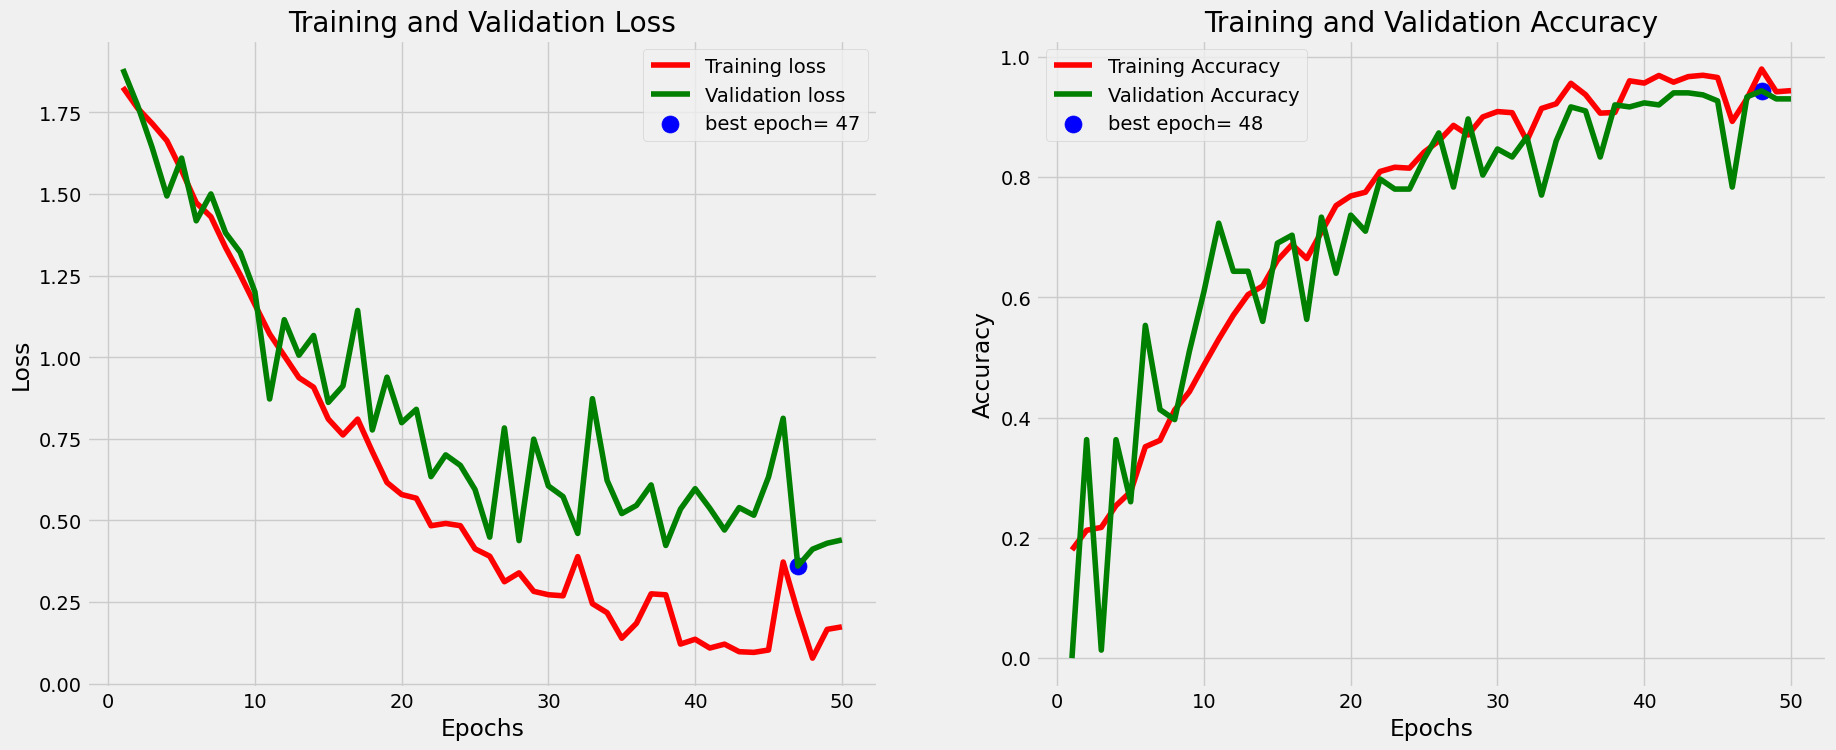

In [48]:
f_history(history4)

> ### Classification Report

In [49]:
# # Classification report
# preds = model4.predict_generator(test_gen)
# y_pred = np.argmax(preds, axis=1)
# print(classification_report(test_gen.classes, y_pred, target_names= classes))

> ### Confussion Matrix

In [50]:
# f_cm(y_pred)

# Save model

In [51]:
# loaded_model1 = tf.keras.models.load_model('/kaggle/working/Model1.h5', compile=False)
# %cd /kaggle/working

In [52]:
# from IPython.display import FileLink -> FileLink(r'Model1.h5')

In [53]:
# #Save the model
# model.save('Model.h5')

**rediction using loaded_model**

In [54]:
# loaded_model = tf.keras.models.load_model('/kaggle/working/Model.h5', compile=False)
# loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [55]:
# image_path = ''
# image = Image.open(image_path)

# # Preprocess the image
# img = image.resize((224, 224))
# img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# # Make predictions
# predictions = loaded_model.predict(img_array)
# class_labels = classes
# score = tf.nn.softmax(predictions[0])
# print(f"{class_labels[tf.argmax(score)]}")

In [56]:
# predictions